## Final Project Submission

Please fill out:
* Student name: JAMES SAVORY
* Student pace: self paced / part time / full time: PART TIME
* Scheduled project review date/time: APRIL 5, 2019 
* Instructor name: BRANDON LEWIS
* Blog post URL:


# Obtaining and Scrubbing the data

### Import Libraries, Data

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns

pd.set_option('display.max_columns', 21)
df = pd.read_csv("kc_house_data.csv")

### Define Necessary Functions

In [2]:
#---Functions---
def generate_dummy_view_data():
    zero_count = 19253
    one_count = 329
    two_count = 956
    three_count = 505
    four_count = 314
    
    total = zero_count + one_count + two_count + three_count + four_count
    zero_probability = zero_count/total
    one_probability = one_count/total
    two_probability = two_count/total
    three_probability= three_count/total
    four_probability= four_count/total
    #probability_dict = print(f'zero_prob:{zero_probability}, one_prob:{one_probability}, two_pro:{two_probability}, three_prob:{three_probability}, four_prob:{four_probability}')
    
    random_num = random.uniform(0,1)
    
    if random_num < four_probability:
        return 4
    elif random_num >= four_probability and random_num < one_probability:
        return 1
    elif random_num >= one_probability and random_num < three_probability:
        return 3
    elif random_num >= three_probability and random_num < two_probability:
        return 2
    else:
        return 0
    

def log_only_nonzero(x):
    if x > 0:
        return np.log(x)
    else:
        return x
    

def min_max_scale(column):
    column_min = min(column)
    column_max = max(column)
    
    return (column - column_min)/(column_max - column_min)

### Manage Incorrect Data Types

In [3]:
df.isna().sum()

#---Waterfront---
df.groupby('waterfront')['id'].nunique()
df['waterfront'].isna().sum()
df['waterfront'].replace(np.NaN, 0,inplace=True) #Replace NaNs with most common value (0)

#---View---
bins = [0,1,2,3,4]
df.groupby('view')['id'].nunique()

dummy = generate_dummy_view_data()
df["view"].replace(np.NaN, dummy,inplace=True) #Interpolate values
#df.isna().sum()

#---Yr_Renovated---
df.groupby('yr_renovated')['id'].nunique()
df["yr_renovated"].replace(np.NaN, 0,inplace=True) #Replace with most common value (0)
df.isna().sum()


#---Sqft_Basement---
df["sqft_basement"].replace('?', np.NaN,inplace=True)
df['sqft_basement'] = df['sqft_basement'].astype('float64')

#---Bedrooms---
df["bedrooms"] = df["bedrooms"].astype('float64')

#df.info()

#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #print(df.groupby('sqft_basement')['id'].nunique())

df["sqft_basement"].replace(np.NaN, 0,inplace=True) #Replace with most common value (0)
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### Remove Colinear Columns

In [4]:
#---Check for, Remove Collinear Columns---
collinear_test = abs(df.corr()) > 0.75
collinear_test.sum()
df = df.drop(['sqft_living', 'bathrooms','grade','sqft_above','sqft_living15','sqft_lot15'],axis=1) #removed sqft_living15, sqft_lot15 also. Could not find definition of columns/significance of '15'
df

,id,date,price,bedrooms,sqft_lot,floors,waterfront,view,condition,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,10/13/2014,221900.0,3.0,5650,1.0,0.0,0.0,3,0.0,1955,0.0,98178,47.5112,-122.257
1,6414100192,12/9/2014,538000.0,3.0,7242,2.0,0.0,0.0,3,400.0,1951,1991.0,98125,47.7210,-122.319
2,5631500400,2/25/2015,180000.0,2.0,10000,1.0,0.0,0.0,3,0.0,1933,0.0,98028,47.7379,-122.233
3,2487200875,12/9/2014,604000.0,4.0,5000,1.0,0.0,0.0,5,910.0,1965,0.0,98136,47.5208,-122.393
4,1954400510,2/18/2015,510000.0,3.0,8080,1.0,0.0,0.0,3,0.0,1987,0.0,98074,47.6168,-122.045
5,7237550310,5/12/2014,1230000.0,4.0,101930,1.0,0.0,0.0,3,1530.0,2001,0.0,98053,47.6561,-122.005
6,1321400060,6/27/2014,257500.0,3.0,6819,2.0,0.0,0.0,3,0.0,1995,0.0,98003,47.3097,-122.327
7,2008000270,1/15/2015,291850.0,3.0,9711,1.0,0.0,0.0,3,0.0,1963,0.0,98198,47.4095,-122.315
8,2414600126,4/15/2015,229500.0,3.0,7470,1.0,0.0,0.0,3,730.0,1960,0.0,98146,47.5123,-122.337
9,3793500160,3/12/2015,323000.0,3.0,6560,2.0,0.0,0.0,3,0.0,2003,0.0,98038,47.3684,-122.031


### Normalize, Feature Scale Data

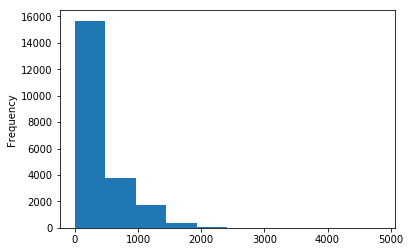

In [5]:
#---Check columns for normality--- 
#price_plot = df.price.plot.hist()
#price_plot.set_xlim(0,4000000) # Price data has a strong positive skew

#bedrooms_plot = df.bedrooms.plot.hist()
#bedrooms_plot.set_xlim(0,10) #Bedrooms data is positively skewed

#sqft_lot_plot = df.sqft_lot.plot.hist()
#sqft_lot_plot.set_xlim(0,500000) #Square foot lot data has strong positive skew

#floors_plot = df.floors.plot.hist()
#floors_plot #Floors data is positively skewed

sqft_basement_plot = df.sqft_basement.plot.hist()
sqft_basement_plot #basement squarefoot data is positively skewed

In [6]:
#---Normalize skewed columns---
df_log = df
df_log.price = np.log(df_log.price)
df_log.sqft_lot = np.log(df_log.sqft_lot)
df_log.floors = df_log.floors.apply(log_only_nonzero)
df_log.sqft_basement = df_log.sqft_basement.apply(log_only_nonzero)
df_log.bedrooms = df_log.bedrooms.apply(log_only_nonzero)

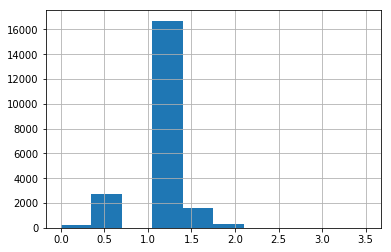

In [7]:
#---Check if successfully normalized---
#df_log.price.hist() #yes
#df_log.sqft_lot.hist() #yes
#df_log.floors.hist() #no, skewed positively with 0s
#df_log.sqft_basement.hist() #no, skewed positively with 0s
df_log.bedrooms.hist() #yes

In [8]:
#---Min-max scale---
df_scaled = df_log
df_scaled.price = min_max_scale(df_scaled.price)
df_scaled.sqft_lot = min_max_scale(df_scaled.sqft_lot)
df_scaled.floors = min_max_scale(df_scaled.floors)
df_scaled.bedrooms = min_max_scale(df_scaled.bedrooms)
df_scaled.sqft_basement = min_max_scale(df_scaled.sqft_basement)

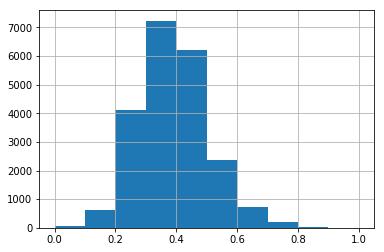

In [9]:
df_scaled.price.hist()
#df_final.sqft_basement.hist()

### One-Hot Encode Categorical Columns

In [20]:
df_encoded = df_scaled
df_encoded.waterfront = df_encoded.waterfront.astype('str')
df_encoded.view = df_encoded.view.astype('str')
df_encoded.condition = df_encoded.condition.astype('str')
#df_encoded.yr_built = df_encoded.yr_built.astype('str')
df_encoded.yr_renovated = df_encoded.yr_renovated.astype('float64')
df_encoded.zipcode = df_encoded.zipcode.astype('str')
#df.info()

#---Encode Views---
view_dummies = pd.get_dummies(df_encoded.view)
view_dummies.columns = ["view_0","view_1","view_2","view_3","view_4"]
df_encoded = pd.concat([df_encoded, view_dummies], axis=1, join='inner')
df_encoded = df_encoded.drop(['view'],axis=1)

#---Encode Condition---
condition_dummies = pd.get_dummies(df_encoded.condition)
condition_dummies.columns = ["condition_1","condition_2","condition_3","condition_4","condition_5"]
df_encoded = pd.concat([df_encoded, condition_dummies], axis=1, join='inner')
df_encoded = df_encoded.drop(['condition'],axis=1)

#---Encode Year Built---
display(df_encoded['yr_built'].describe()) #Get percentiles for bins

def under_25_percentile_check(y):
    if y>=1900 and y<1951:
        return 1
    else:
        return 0
    
def under_50_percentile_check(y1):
    if y1>=1951 and y1<1975:
        return 1
    else:
        return 0

def under_75_percentile_check(y2):
    if y2 >=1975 and y2<1997:
        return 1
    else:
        return 0
    
def under_100_percentile_check(y3):
    if y3 >=1997 and y3 <2016:
        return 1
    else:
        return 0

yr_built_bins = ['yr_built: 1900 - 1950', 'yr_built: 1951 - 1974', 'yr_built: 1975 - 1996', 'yr_built: 1997 - 2015']

for i in range(0,4):
    if i == 0:
        df_encoded[yr_built_bins[i]] = df_encoded.yr_built.apply(under_25_percentile_check)
    elif i == 1:
        df_encoded[yr_built_bins[i]] = df_encoded.yr_built.apply(under_50_percentile_check)
    elif i == 2:
        df_encoded[yr_built_bins[i]] = df_encoded.yr_built.apply(under_75_percentile_check)
    elif i == 3:
        df_encoded[yr_built_bins[i]] = df_encoded.yr_built.apply(under_100_percentile_check)
    

df_encoded

#---Encode Year Renovated---
renovated_list = sorted((list(df_encoded['yr_renovated'].unique())))#.describe()) #Get percentiles for bins
renovated_list_q1_index = int(len(renovated_list)/4)
renovated_list_q2_index = int(len(renovated_list)/2)
renovated_list_q3_index = int(len(renovated_list)/2) + int(len(renovated_list)/4)

renovated_list
renovated_list_nonzero_min = str(renovated_list[1])
renovated_list_q1 = str(renovated_list[renovated_list_q1_index])
renovated_list_q2 = str(renovated_list[renovated_list_q2_index])
renovated_list_q3 = str(renovated_list[renovated_list_q3_index])
renovated_list_max = str(renovated_list[-1])


#print(renovated_list_nonzero_min, renovated_list_q1, renovated_list_q2, renovated_list_q3, renovated_list_max)

yr_renovated_bins = ['yr_renovated: none', 'yr_renovated: 1934 - 1961', 'yr_renovated: 1962 - 1980', 'yr_renovated: 1981 - 1998', 'yr_renovated: 1999 - 2015']

def is_it_zero(z4):
    if z4 == 0:
        return 1
    else:
        return 0

def under_25_percentile_check_1(z):
    if z>=1934 and z<1962:
        return 1
    else:
        return 0
    
def under_50_percentile_check_1(z1):
    if z1>=1962 and z1<1981:
        return 1
    else:
        return 0

def under_75_percentile_check_1(z2):
    if z2 >=1981 and z2<1999:
        return 1
    else:
        return 0
    
def under_100_percentile_check_1(z3):
    if z3 >=1999 and z3 <2016:
        return 1
    else:
        return 0
    
for j in range(0,5):
    if j == 0:
        df_encoded[yr_renovated_bins[j]] = df_encoded.yr_renovated.apply(is_it_zero)
    elif j == 1:
        df_encoded[yr_renovated_bins[j]] = df_encoded.yr_renovated.apply(under_25_percentile_check_1)
    elif j == 2:
        df_encoded[yr_renovated_bins[j]] = df_encoded.yr_renovated.apply(under_50_percentile_check_1)
    elif j == 3:
        df_encoded[yr_renovated_bins[j]] = df_encoded.yr_renovated.apply(under_75_percentile_check_1)
    elif j == 4:
        df_encoded[yr_renovated_bins[j]] = df_encoded.yr_renovated.apply(under_100_percentile_check_1)

df_encoded

count    21597.000000
mean      1970.999676
std         29.375234
min       1900.000000
25%       1951.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

,id,date,price,bedrooms,sqft_lot,floors,waterfront,sqft_basement,yr_built,yr_renovated,...,condition_5,yr_built: 1900 - 1950,yr_built: 1951 - 1974,yr_built: 1975 - 1996,yr_built: 1997 - 2015,yr_renovated: none,yr_renovated: 1934 - 1961,yr_renovated: 1962 - 1980,yr_renovated: 1981 - 1998,yr_renovated: 1999 - 2015
0,7129300520,10/13/2014,0.227669,0.314203,0.295858,0.000000,0.0,0.000000,1955,0.0,...,0,0,1,0,0,1,0,0,0,0
1,6414100192,12/9/2014,0.420522,0.314203,0.326644,0.553295,0.0,0.706497,1951,1991.0,...,0,0,1,0,0,0,0,0,1,0
2,5631500400,2/25/2015,0.182099,0.198240,0.366664,0.000000,0.0,0.000000,1933,0.0,...,0,1,0,0,0,1,0,0,0,0
3,2487200875,12/9/2014,0.445720,0.396480,0.280700,0.000000,0.0,0.803422,1965,0.0,...,1,0,1,0,0,1,0,0,0,0
4,1954400510,2/18/2015,0.408883,0.314203,0.340224,0.000000,0.0,0.000000,1987,0.0,...,0,0,0,1,0,1,0,0,0,0
5,7237550310,5/12/2014,0.600588,0.396480,0.654599,0.000000,0.0,0.864689,2001,0.0,...,0,0,0,0,1,1,0,0,0,0
6,1321400060,6/27/2014,0.260070,0.314203,0.319180,0.553295,0.0,0.000000,1995,0.0,...,0,0,0,1,0,1,0,0,0,0
7,2008000270,1/15/2015,0.287338,0.314203,0.363027,0.000000,0.0,0.000000,1963,0.0,...,0,0,1,0,0,1,0,0,0,0
8,2414600126,4/15/2015,0.235003,0.314203,0.330489,0.000000,0.0,0.777433,1960,0.0,...,0,0,1,0,0,1,0,0,0,0
9,3793500160,3/12/2015,0.309421,0.314203,0.314378,0.553295,0.0,0.000000,2003,0.0,...,0,0,0,0,1,1,0,0,0,0
